# CNN + GlobalAvgPool 
Based on CNN 107 which got 75% acc on H1 coding len 2000-4000.  
Model: Embed mask, Conv1D, GlobalAvgPool.   

H1 coding len 3000-4000.  
Cross validation 5 folds 5 epochs, accuracy mean , F1 mean 

Same as CNN 118 but switch cell line 1 to 2.

In [153]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-12-29 16:06:50.658944
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [154]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Flatten
from keras.layers import Attention
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
CFILTERS=64
FILTERSIZE=8
RCELLS=16
DCELLS=8
EPOCHS=5
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=3000
MAXLEN=4000   

In [155]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [156]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [157]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=2
all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 2 = HeLa.S3


## Data Load

In [158]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields[0]
                    rci_val = fields[cell_line+1]
                    if rci_val != "nan":
                        # Convert string nan to float(nan)
                        gene_to_rci[gene_id] = float(rci_val)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [159]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE_NUMBER)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2022-12-29 16:06:53.318737
Load RCI values...
Num RCI: 6983
Example RCI: [('ENSG00000000003', 1.86839), ('ENSG00000000419', 1.27556), ('ENSG00000000457', -0.267569)]
Load genes...
2022-12-29 16:06:53.350422
Load sequence...
2022-12-29 16:07:00.182660
Num IDs: 4095
Example IDs: [('ENSG00000069424', 'ENST00000669250.1'), ('ENSG00000171680', 'ENST00000673471.2'), ('ENSG00000120949', 'ENST00000263932.7'), ('ENSG00000142619', 'ENST00000375460.3')]
Count 1892 ones out of 4095 labels.
Example labels: [0, 0, 1, 0]
Num counts: 4095
Example sequence: [179, 201, 34, 135, 28, 111, 187, 234, 167, 155, 107, 170, 167, 155, 105, 162, 134, 22, 87, 91, 107, 171, 171, 170, 167, 154, 102, 150, 88, 94, 118, 215, 91, 105, 162, 135, 26, 103, 155, 106, 165, 147, 75, 42, 165, 148, 78, 53, 211, 76, 47, 188, 240, 192, 256, 256, 254, 248, 223, 121, 226, 134, 23, 89, 97, 131, 12, 48, 190, 248, 222, 117, 212, 80, 64, 254, 246, 216, 95, 121, 226, 133, 17, 68, 15, 59, 233, 161, 129, 4, 15, 59, 233, 161, 130, 5, 17, 6

## Model

In [160]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    #rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=False) )
    #pool_layer = MaxPooling1D(pool_size=3)
    pool_layer = GlobalAveragePooling1D()
    #pool_layer = GlobalMaxPooling1D()
    flat_layer = Flatten()
    den1_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    rnn.add(embed_layer)
    rnn.add(cnn1_layer)
    rnn.add(pool_layer)
    #rnn.add(flat_layer)
    #rnn.add(den1_layer)
    #rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [161]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-12-29 16:07:00.221884
COMPILE
Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_79 (Embedding)    (None, 3997, 4)           1028      
                                                                 
 conv1d_79 (Conv1D)          (None, 3990, 64)          2112      
                                                                 
 global_average_pooling1d_66  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_157 (Dense)           (None, 1)                 65        
                                                                 
Total params: 3,205
Trainable params: 3,205
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [162]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,pred_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = pred_threshold # e.g. score>0.5 => class 1
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2022-12-29 16:07:00.564501
2022-12-29 16:07:00.565049
splitting
Fold 1
Training example
[ 62 246 215 ...   0   0   0]
Train sizes (3241, 3997) (3241, 1)
Valid sizes (854, 3997) (854, 1)
Train set ones/size 1558 / 3241
Valid set ones/size 334 / 854
BUILD MODEL
COMPILE
FIT
2022-12-29 16:07:01.591872
Epoch 1/5
102/102 [==============================] - 2s 10ms/step - loss: 0.6577 - accuracy: 0.6017 - val_loss: 0.5956 - val_accuracy: 0.6803
Epoch 2/5
102/102 [==============================] - 1s 8ms/step - loss: 0.5920 - accuracy: 0.6754 - val_loss: 0.5808 - val_accuracy: 0.6792
Epoch 3/5
102/102 [==============================] - 1s 7ms/step - loss: 0.5876 - accuracy: 0.6773 - val_loss: 0.5828 - val_accuracy: 0.6780
Epoch 4/5
102/102 [==============================] - 1s 7ms/step - loss: 0.5834 - accuracy: 0.6831 - val_loss: 0.5712 - val_accuracy: 0.6803
Epoch 5/5
102/102 [==============================] - 1s 7ms/step - loss: 0.5802 - accuracy: 0.6782 - val_loss: 0.5616 - val_accuracy: 0.

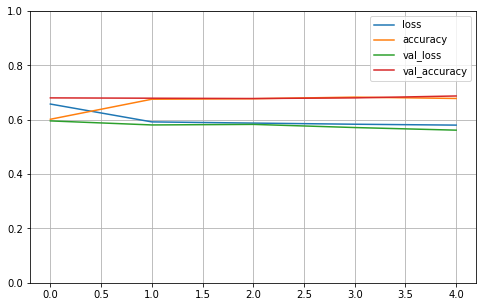

Compute valiation accuracy
2022-12-29 16:07:07.506387
Range of scores: 0.05059282 to 0.8517713
Predicted zeros and ones 533 321
Accuracy: 68.74% Precision: 60.44% Recall: 58.08% F1: 59.24%
2022-12-29 16:07:07.694548
Fold 2
Training example
[ 62 246 215 ...   0   0   0]
Train sizes (3370, 3997) (3370, 1)
Valid sizes (725, 3997) (725, 1)
Train set ones/size 1569 / 3370
Valid set ones/size 323 / 725
BUILD MODEL
COMPILE
FIT
2022-12-29 16:07:08.691670
Epoch 1/5
106/106 [==============================] - 1s 9ms/step - loss: 0.6561 - accuracy: 0.5964 - val_loss: 0.6000 - val_accuracy: 0.6607
Epoch 2/5
106/106 [==============================] - 1s 8ms/step - loss: 0.5878 - accuracy: 0.6780 - val_loss: 0.5947 - val_accuracy: 0.6566
Epoch 3/5
106/106 [==============================] - 1s 8ms/step - loss: 0.5837 - accuracy: 0.6849 - val_loss: 0.5936 - val_accuracy: 0.6690
Epoch 4/5
106/106 [==============================] - 1s 7ms/step - loss: 0.5797 - accuracy: 0.6896 - val_loss: 0.5937 - val_ac

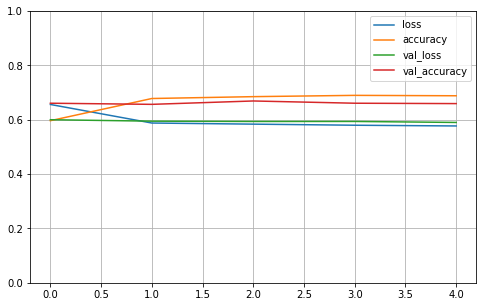

Compute valiation accuracy
2022-12-29 16:07:14.581569
Range of scores: 0.028659133 to 0.9120693
Predicted zeros and ones 411 314
Accuracy: 65.93% Precision: 62.10% Recall: 60.37% F1: 61.22%
2022-12-29 16:07:14.749874
Fold 3
Training example
[ 47 187 235 ...   0   0   0]
Train sizes (3318, 3997) (3318, 1)
Valid sizes (777, 3997) (777, 1)
Train set ones/size 1500 / 3318
Valid set ones/size 392 / 777
BUILD MODEL
COMPILE
FIT
2022-12-29 16:07:15.732244
Epoch 1/5
104/104 [==============================] - 2s 10ms/step - loss: 0.6552 - accuracy: 0.5814 - val_loss: 0.5962 - val_accuracy: 0.6795
Epoch 2/5
104/104 [==============================] - 1s 8ms/step - loss: 0.5918 - accuracy: 0.6694 - val_loss: 0.5826 - val_accuracy: 0.6898
Epoch 3/5
104/104 [==============================] - 1s 8ms/step - loss: 0.5851 - accuracy: 0.6760 - val_loss: 0.5824 - val_accuracy: 0.6847
Epoch 4/5
104/104 [==============================] - 1s 7ms/step - loss: 0.5816 - accuracy: 0.6796 - val_loss: 0.5898 - val_

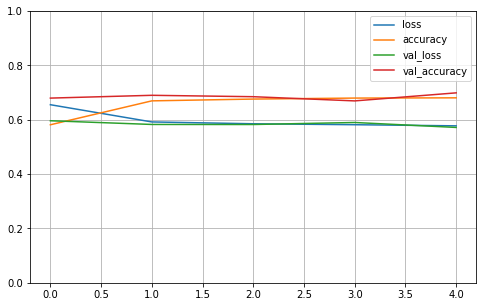

Compute valiation accuracy
2022-12-29 16:07:21.640447
Range of scores: 0.06965514 to 0.89139336
Predicted zeros and ones 379 398
Accuracy: 69.88% Precision: 69.85% Recall: 70.92% F1: 70.38%
2022-12-29 16:07:21.884177
Fold 4
Training example
[ 62 246 215 ...   0   0   0]
Train sizes (3169, 3997) (3169, 1)
Valid sizes (926, 3997) (926, 1)
Train set ones/size 1419 / 3169
Valid set ones/size 473 / 926
BUILD MODEL
COMPILE
FIT
2022-12-29 16:07:22.892941
Epoch 1/5
100/100 [==============================] - 2s 10ms/step - loss: 0.6692 - accuracy: 0.5639 - val_loss: 0.6115 - val_accuracy: 0.6728
Epoch 2/5
100/100 [==============================] - 1s 7ms/step - loss: 0.5933 - accuracy: 0.6737 - val_loss: 0.5932 - val_accuracy: 0.6771
Epoch 3/5
100/100 [==============================] - 1s 8ms/step - loss: 0.5860 - accuracy: 0.6750 - val_loss: 0.5789 - val_accuracy: 0.6933
Epoch 4/5
100/100 [==============================] - 1s 8ms/step - loss: 0.5814 - accuracy: 0.6844 - val_loss: 0.5777 - val_

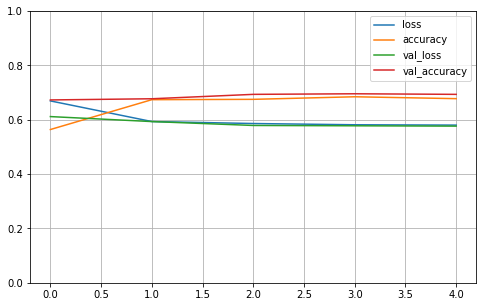

Compute valiation accuracy
2022-12-29 16:07:28.161792
Range of scores: 0.06460234 to 0.9354631
Predicted zeros and ones 423 503
Accuracy: 69.33% Precision: 68.79% Recall: 73.15% F1: 70.90%
2022-12-29 16:07:28.419412
Fold 5
Training example
[ 62 246 215 ...   0   0   0]
Train sizes (3282, 3997) (3282, 1)
Valid sizes (813, 3997) (813, 1)
Train set ones/size 1522 / 3282
Valid set ones/size 370 / 813
BUILD MODEL
COMPILE
FIT
2022-12-29 16:07:29.417286
Epoch 1/5
103/103 [==============================] - 2s 10ms/step - loss: 0.6527 - accuracy: 0.5945 - val_loss: 0.6100 - val_accuracy: 0.6642
Epoch 2/5
103/103 [==============================] - 1s 8ms/step - loss: 0.5829 - accuracy: 0.6831 - val_loss: 0.6096 - val_accuracy: 0.6642
Epoch 3/5
103/103 [==============================] - 1s 7ms/step - loss: 0.5780 - accuracy: 0.6877 - val_loss: 0.6184 - val_accuracy: 0.6753
Epoch 4/5
103/103 [==============================] - 1s 8ms/step - loss: 0.5755 - accuracy: 0.6849 - val_loss: 0.6084 - val_a

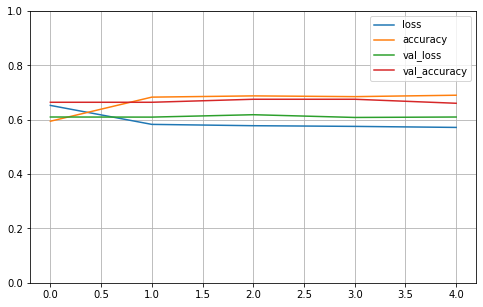

Compute valiation accuracy
2022-12-29 16:07:35.307436
Range of scores: 0.04705602 to 0.9041927
Predicted zeros and ones 419 394
Accuracy: 66.05% Precision: 61.93% Recall: 65.95% F1: 63.87%
2022-12-29 16:07:35.561712

Cross validation 5 folds 5 epochs
 accuracy mean 67.99% +/- 1.67
 precision mean 64.62% +/- 3.89
 recall mean 65.69% +/- 5.82
 F1 mean 65.12% +/- 4.74
2022-12-29 16:07:35.564214


In [163]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())